# Getting Started

Follow the general instructions from hw1_Q1

In [1]:
# get to the parent dir of mai_dul repo
import os

from torch.utils.data import DataLoader, TensorDataset

from models.BinaryPixelCNN import BinaryPixelCNN

os.getcwd()

'/home/ordem/PycharmProjects/MAI_DUL_WS24/homeworks/hw1'

In [2]:
# run only once at the beginning of working on hw1
# !unzip -qq data/hw1_data.zip -d data/

# install latest version deepul package
# !pip install -e .

# Question 2 PixelCNNs

Now, we will work with a higher dimensional datasets.
We will start from black-and-white shape dataset and MNIST, in the second part we will extend to modeling colored datasets.

Run the cell below to visualize the two binary datasets.

In [3]:
import numpy as np
from deepul.hw1_helper import (
    # Q2
    q2a_save_results,
    q2b_save_results,
    visualize_q2a_data,
    visualize_q2b_data,
)

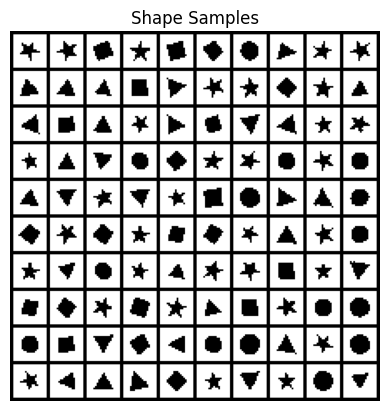

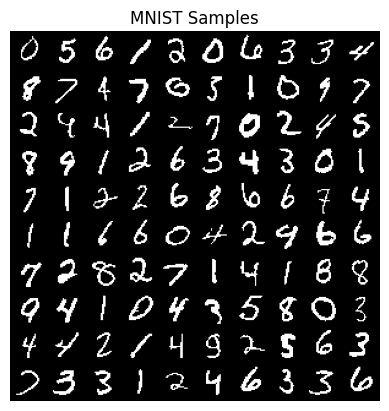

In [4]:
visualize_q2a_data(1)
visualize_q2a_data(2)

## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images.

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

Checkout the Paper for more details: https://arxiv.org/abs/1601.06759

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [5]:
import torch
from torch.optim import Adam


def q2_a(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
    batch_size = 128
    learning_rate = 0.001
    max_epochs = 20

    # rescale from 0/1 to -1/+1
    train_dataset = TensorDataset((torch.tensor(train_data).permute((0, 3, 1, 2)).float() * 2) - 1)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    x_test = (torch.tensor(test_data).permute((0, 3, 1, 2)).float() * 2) - 1

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    x_test = x_test.to(device)

    model = BinaryPixelCNN(filters=32)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    test_losses = []
    for epoch in range(max_epochs):
        batches = iter(train_loader)

        batch_train_loss = np.empty(len(batches))
        for i, [batch_x] in enumerate(batches):
            batch_x = batch_x.to(device)
            logits = model.forward(batch_x)

            loss = model.loss_function(batch_x, logits)
            batch_train_loss[i] = loss

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        train_losses.append(batch_train_loss.mean().item())

        model.eval()
        with torch.no_grad():
            test_logits = model.forward(x_test)
            test_loss = model.loss_function(x_test, test_logits)
            test_losses.append(test_loss.item())
        model.train()
        print(f"epoch {epoch + 1}/{max_epochs}, train loss: {train_losses[-1]}, test loss: {test_losses[-1]}")
    samples = model.generate(100, device).permute((0, 2, 3, 1)).numpy(force=True)
    return train_losses, test_losses, samples

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



epoch 1/20, train loss: 0.25748210545720124, test loss: 0.1435183435678482
epoch 2/20, train loss: 0.13712667110489635, test loss: 0.12981663644313812
epoch 3/20, train loss: 0.12363468419487883, test loss: 0.11283542960882187
epoch 4/20, train loss: 0.10406419816540509, test loss: 0.09498406201601028
epoch 5/20, train loss: 0.08691736828626656, test loss: 0.07818932831287384
epoch 6/20, train loss: 0.07549318198750658, test loss: 0.0740816667675972
epoch 7/20, train loss: 0.06773071304508825, test loss: 0.06465242803096771
epoch 8/20, train loss: 0.06298502148469774, test loss: 0.06203765049576759
epoch 9/20, train loss: 0.05976117952022611, test loss: 0.05785016342997551
epoch 10/20, train loss: 0.056174873442548075, test loss: 0.053801748901605606
epoch 11/20, train loss: 0.053202937152691004, test loss: 0.05284823849797249
epoch 12/20, train loss: 0.05147736855759853, test loss: 0.05009079352021217
epoch 13/20, train loss: 0.04982411734214643, test loss: 0.048455335199832916
epoch 

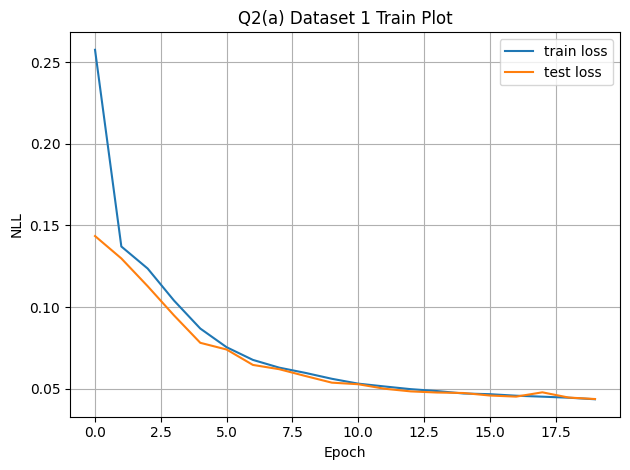

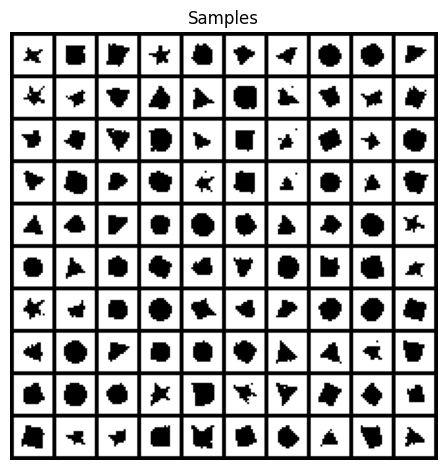

In [6]:
q2a_save_results(1, q2_a)

epoch 1/20, train loss: 0.1532582593625034, test loss: 0.09523429721593857
epoch 2/20, train loss: 0.089640073335247, test loss: 0.08701328188180923
epoch 3/20, train loss: 0.08610102883788315, test loss: 0.08421460539102554
epoch 4/20, train loss: 0.08411384829834326, test loss: 0.08303554356098175
epoch 5/20, train loss: 0.08267900231741131, test loss: 0.08131549507379532
epoch 6/20, train loss: 0.08184111024588664, test loss: 0.08112973719835281
epoch 7/20, train loss: 0.08113533145646805, test loss: 0.08044438809156418
epoch 8/20, train loss: 0.08050539835429649, test loss: 0.08011104166507721
epoch 9/20, train loss: 0.08011673438523624, test loss: 0.07991880923509598
epoch 10/20, train loss: 0.07961852127300904, test loss: 0.07897452265024185
epoch 11/20, train loss: 0.0792885621123985, test loss: 0.07932396978139877
epoch 12/20, train loss: 0.07898529707940656, test loss: 0.07898308336734772
epoch 13/20, train loss: 0.07881325588170399, test loss: 0.07903876155614853
epoch 14/20,

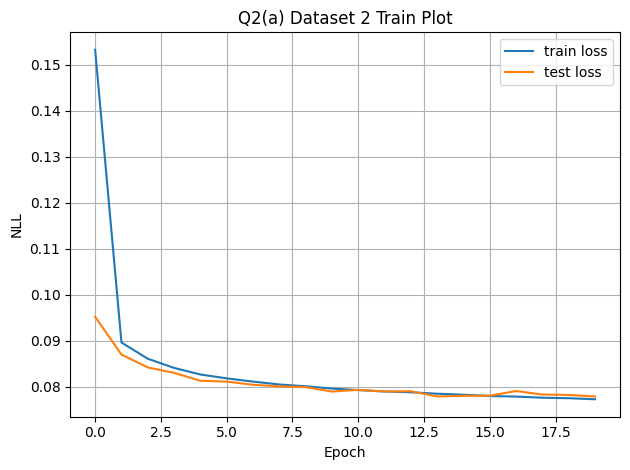

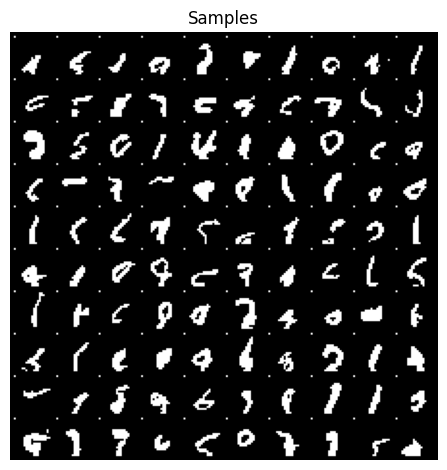

In [7]:
q2a_save_results(2, q2_a)